# Práctica 3 - Tercera prueba

#### Pilar Navarro Ramírez

In [1]:
import pandas as pd

## Preprocesamiento

In [2]:
df_train=pd.read_csv("data/train.csv",na_values=[""])
df_test=pd.read_csv("data/test.csv",na_values=[""])

In [3]:
df_train.columns = [col.lower() for col in df_train]
df_test.columns = [col.lower() for col in df_test]

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

del df_train["id"]
del df_test["id"]

### Tratamos los datos perdidos

In [4]:
from sklearn import impute

In [5]:
del df_train['descuento']
del df_test['descuento']

In [6]:
df_train_replaced=df_train.copy()
imputer=impute.SimpleImputer(strategy="most_frequent")
values = imputer.fit_transform([df_train_replaced.asientos.values])
df_train_replaced.asientos.update(pd.Series(values[0]))

In [7]:
df_train_replaced=df_train_replaced.dropna()
df_train=df_train.dropna()

Separamos el atributo a predecir del resto de atributos en el conjunto de entrenamiento.

In [8]:
cols = [col for col in df_train.columns if col not in ['precio_cat']]    
df_train, df_train_obj= df_train[cols], df_train['precio_cat']
df_train_replaced, df_train_obj_replaced= df_train_replaced[cols], df_train_replaced['precio_cat']

### 'Transformación' de variables categóricas a numéricas

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]

df_train_num=df_train.copy()
df_train_num_rpl=df_train_replaced.copy()
df_test_num=df_test.copy()

for atributo in categorical:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    label = LabelEncoder().fit(data[atributo])
    df_train_num[atributo]=label.transform(df_train[atributo])
    df_train_num_rpl[atributo]=label.transform(df_train_replaced[atributo])
    df_test_num[atributo]=label.transform(df_test[atributo])

### Normalización de los datos

In [10]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cols = [col for col in df_train_orig.columns if col not in ['precio_cat','id','descuento']]  
categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]

df_train_norm=df_train_num.copy()
df_train_norm_rpl=df_train_num_rpl.copy()
df_test_norm=df_test_num.copy()


for atributo in cols:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    if atributo in categorical:
        label = LabelEncoder().fit(data[atributo])
        data[atributo]=label.transform(data[atributo])
    scaler = MinMaxScaler().fit(data.values)
    train_values=df_train_num[atributo].values.reshape(-1,1)
    df_train_norm[atributo]=scaler.transform(train_values)
    train_values_rpl=df_train_num_rpl[atributo].values.reshape(-1,1)
    df_train_norm_rpl[atributo]=scaler.transform(train_values_rpl)
    test_values=df_test_num[atributo].values.reshape(-1,1)
    df_test_norm[atributo]=scaler.transform(test_values)
    

## Aplicación de los algoritmos

In [11]:
import numpy as np

from sklearn.model_selection import cross_val_score

def cross_validation(clf,x,y,mostrar=False):
    scores=cross_val_score(clf,x,y,scoring='accuracy',cv=5)
    accuracy=np.mean(scores)  
    if mostrar:
        print("Accuracy: ", accuracy)
    return accuracy

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier

knn=KNeighborsClassifier()
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=0.5, max_features=0.5, random_state=10)
forest=RandomForestClassifier(random_state=10)
extra=ExtraTreesClassifier(random_state=10)
ada=AdaBoostClassifier(random_state=10)
gradient=GradientBoostingClassifier(random_state=10,max_features='auto')

clfs=[gradient,ada,bagging_knn,forest,extra]

for clf in clfs:
    print("Datos normalizados con todos nulos eliminados: ")
    print(clf)
    cross_validation(clf, df_train_norm, df_train_obj,True)
    print("Datos normalizados con nulos en asientos reemplazados: ")
    print(clf)
    cross_validation(clf,df_train_norm_rpl,df_train_obj_replaced,True)

Datos normalizados con todos nulos eliminados: 
GradientBoostingClassifier(max_features='auto', random_state=10)
Accuracy:  0.8065480649188513
Datos normalizados con nulos en asientos reemplazados: 
GradientBoostingClassifier(max_features='auto', random_state=10)
Accuracy:  0.8055231940133509
Datos normalizados con todos nulos eliminados: 
AdaBoostClassifier(random_state=10)
Accuracy:  0.6755895755305867
Datos normalizados con nulos en asientos reemplazados: 
AdaBoostClassifier(random_state=10)
Accuracy:  0.604655202784375
Datos normalizados con todos nulos eliminados: 
BaggingClassifier(base_estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5, n_estimators=50, random_state=10)
Accuracy:  0.7803058676654182
Datos normalizados con nulos en asientos reemplazados: 
BaggingClassifier(base_estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5, n_estimators=50, random_state=10)
Accuracy:  0.7636193837201534
Datos normalizados 

### Configuración de los parámetros

##### Knn

In [12]:
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def tune_knn(max_value):
    acc=[]
    for i in range(2,max_value):
        knn=KNeighborsClassifier(n_neighbors=i)
        acc.append(cross_validation(knn,df_train_norm,df_train_obj))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(2,max_value), acc)
    ax.set_title('Vecino más cercano')
    ax.set_xlabel('Num vecinos')
    ax.set_ylabel('Accuracy')
    plt.show()

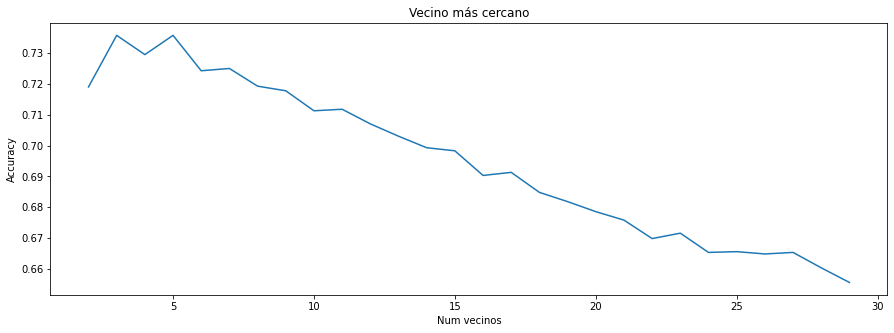

In [14]:
tune_knn(30)

ERROR! Session/line number was not unique in database. History logging moved to new session 28


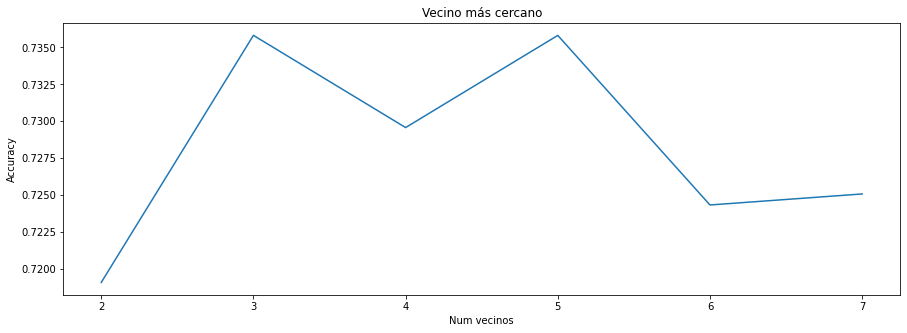

In [13]:
tune_knn(8)

#### Bagging con Knn

Configurando el parámetro max_samples.

In [75]:
knn=KNeighborsClassifier()
print("Bagging con knn y max_samples= 0.5")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=0.5, max_features=0.5, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_samples= 0.8")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=0.8, max_features=0.5, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_samples= 0.9")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=0.9, max_features=0.5, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_samples= 1.0")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=1.0, max_features=0.5, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)

Bagging con knn y max_samples= 0.5
Accuracy:  0.7803058676654182
Bagging con knn y max_samples= 0.8
Accuracy:  0.7920505617977527
Bagging con knn y max_samples= 0.9
Accuracy:  0.795549313358302
Bagging con knn y max_samples= 1.0
Accuracy:  0.7995486891385768


0.7995486891385768

Configurando el parámetro max_features.

In [80]:
knn=KNeighborsClassifier()
print("Bagging con knn y max_features= 0.5")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=1.0, max_features=0.5, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_features= 0.4")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=1.0, max_features=0.4, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_features= 0.6")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=1.0, max_features=0.6, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_features= 0.8")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=1.0, max_features=0.8, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)
print("Bagging con knn y max_features= 0.7")
bagging_knn= BaggingClassifier(knn,n_estimators=50, max_samples=1.0, max_features=0.7, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)

Bagging con knn y max_features= 0.5
Accuracy:  0.7995486891385768
Bagging con knn y max_features= 0.4
Accuracy:  0.7942974406991261
Bagging con knn y max_features= 0.6
Accuracy:  0.8030477528089888
Bagging con knn y max_features= 0.8
Accuracy:  0.7753080524344569
Bagging con knn y max_features= 0.7
Accuracy:  0.7888033707865169


0.7888033707865169

Configuramos el número de estimadores.

In [21]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
knn=KNeighborsClassifier()
def tune_bagging_knn(max_value):
    acc=[]
    for i in range(2,max_value):
        bagging_knn= BaggingClassifier(knn,n_estimators=i, max_samples=1.0, max_features=0.6, random_state=10)
        acc.append(cross_validation(bagging_knn,df_train_norm,df_train_obj))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(2,max_value), acc)
    ax.set_title('Bagging con knn')
    ax.set_xlabel('Num estimadores')
    ax.set_ylabel('Accuracy')
    plt.show()

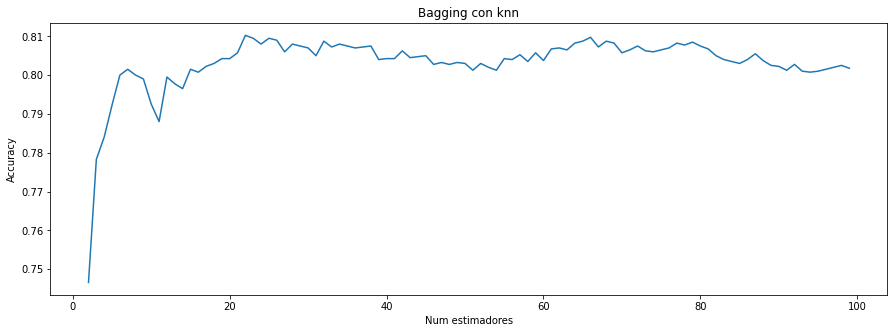

In [27]:
tune_bagging_knn(100)

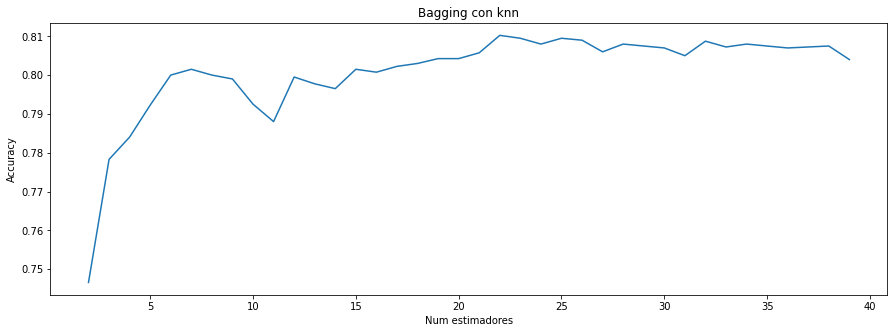

In [22]:
tune_bagging_knn(40)

In [26]:
bagging_knn= BaggingClassifier(knn,n_estimators=22, max_samples=1.0, max_features=0.6, random_state=10)
cross_validation(bagging_knn,df_train_norm,df_train_obj,True)

Accuracy:  0.8102943196004995


0.8102943196004995

#### Gradient Boosting

In [58]:
print("Fraction of samples to be used for fitting the individual base learners = 0.8")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.8)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.6")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.9")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.9)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.7")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.7)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Fraction of samples to be used for fitting the individual base learners = 0.8
Accuracy:  0.8100490012484395
Fraction of samples to be used for fitting the individual base learners = 0.6
Accuracy:  0.8102983770287141
Fraction of samples to be used for fitting the individual base learners = 0.9
Accuracy:  0.8112983770287141
Fraction of samples to be used for fitting the individual base learners = 0.7
Accuracy:  0.8118005617977527
Fraction of samples to be used for fitting the individual base learners = 0.75
Accuracy:  0.808051186017478
Fraction of samples to be used for fitting the individual base learners = 0.95
Accuracy:  0.806549313358302


0.806549313358302

Configurando el parámetro max_depth de cada estimador.

In [ ]:
def tune_gradient_boosting(max_value):
    acc=[]
    for i in range(1,max_value):
        gradient=GradientBoostingClassifier(max_depth=i,random_state=10,subsample=0.7)
        acc.append(cross_validation(gradient,df_train_norm,df_train_obj))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(1,max_value), acc)
    ax.set_title('Gradient Boosting')
    ax.set_xlabel('Max depth')
    ax.set_ylabel('Accuracy')
    plt.show()

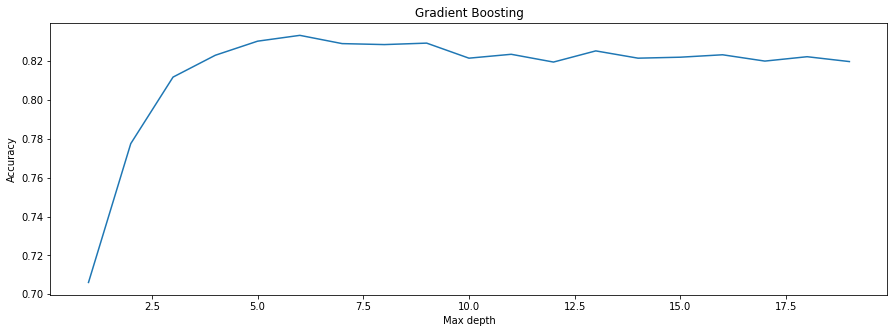

In [28]:
tune_gradient_boosting(20)

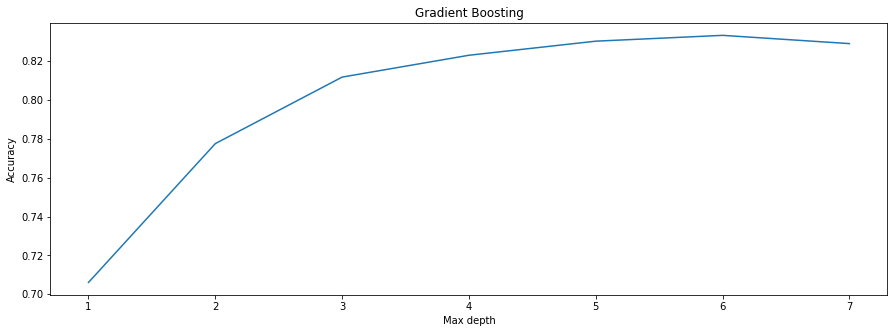

In [24]:
tune_gradient_boosting(8)

Configurando el número de estimadores.

In [ ]:
print("Número de árboles = 300")
gradient=GradientBoostingClassifier(n_estimators=300, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Número de árboles = 200")
gradient=GradientBoostingClassifier(n_estimators=200, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Número de árboles = 100")
gradient=GradientBoostingClassifier(n_estimators=100, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Número de árboles = 50")
gradient=GradientBoostingClassifier(n_estimators=50, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Configurando el parámetro learning_rate.

In [114]:
print("Learning rate=0.2")
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Learning rate=0.3")
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.3, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Learning rate=0.5")
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Learning rate=0.2
Accuracy:  0.8320402621722847
Learning rate=0.3
Accuracy:  0.8210433832709114
Learning rate=0.5
Accuracy:  0.8117936953807741


0.8117936953807741

In [115]:
print("Learning rate=0.15")
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.15, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)
print("Learning rate=0.25")
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Learning rate=0.15
Accuracy:  0.8312899500624219
Learning rate=0.25
Accuracy:  0.8307911985018727


0.8307911985018727

In [116]:
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.7,max_depth=6)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Accuracy:  0.8320402621722847


0.8320402621722847

In [117]:
gradient=GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.9,max_depth=5)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Accuracy:  0.8340405742821474


0.8340405742821474

In [118]:
gradient=GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.9,max_depth=5)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Accuracy:  0.8340405742821474


0.8340405742821474

In [119]:
gradient=GradientBoostingClassifier(n_estimators=150, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.9,max_depth=5)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Accuracy:  0.8347896379525593


0.8347896379525593

In [120]:
from sklearn.model_selection import GridSearchCV

gradient=GradientBoostingClassifier(random_state=10,max_features='auto')
parameter_space = {
    'n_estimators': [100,150,200,250],
    'learning_rate': [0.2,0.1,0.3],
    'subsample': [0.9, 0.7,0.6,0.8],
    'max_depth':[5,6],
}

clf=GridSearchCV(gradient, parameter_space, n_jobs=-1, cv=5)
clf.fit(df_train_norm,df_train_obj)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='auto',
                                                  random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.1, 0.3], 'max_depth': [5, 6],
                         'n_estimators': [100, 150, 200, 250],
                         'subsample': [0.9, 0.7, 0.6, 0.8]})

In [121]:
print('Mejores parámetros: ', clf.best_params_)

Mejores parámetros:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [122]:
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.8,max_depth=5)
cross_validation(gradient,df_train_norm,df_train_obj,True)

Accuracy:  0.8360374531835205


0.8360374531835205

In [15]:
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.8,max_depth=5)
cross_validation(gradient,df_train_norm_rpl,df_train_obj_replaced,True)

Accuracy:  0.8328797993111952


0.8328797993111952

### Aplicación al conjunto de test

#### Entrega 3

In [97]:
knn=KNeighborsClassifier()
bagging_knn= BaggingClassifier(knn,n_estimators=22, max_samples=1.0, max_features=0.6, random_state=10)
bagging_knn.fit(df_train_norm,df_train_obj)
pred=bagging_knn.predict(df_test_norm)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_3.csv", index=False)

In [98]:
df_result.head()

,id,Precio_cat
0,4820,5
1,4821,2
2,4822,2
3,4823,3
4,4824,2


#### Entrega 4

In [123]:
gradient=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.8,max_depth=5)
gradient.fit(df_train_norm,df_train_obj)
pred=gradient.predict(df_test_norm)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_4.csv", index=False)